# Data and model monitoring

## Introduction to monitoring

Many data scientists think about creating the model, maybe deploying it, and end there. However, everything that happens after the model enters production can be equally important. The main area is model observability and monitoring, where we analyze the data and model behavior in time, looking for significant changes. They are known as data drift and concept drift, respectively. Due to real-world changes, the performance of models degrades through time. Monitoring allows us to detect such changes, including said degradation. Observability means detecting root causes and understanding the reasons for changes.

When implementing an observability system, we have to select quantitative measures to monitor these over time changes. In a typical software engineering system we measure latency, requests per second, memory usage etc., and those are certainly important also for ML observability. However, monitoring data and model is often less straightforward.

*Example*: model performance degrades in time, and this behavior can be corrected by monitoring, detecting problems, and retraining.

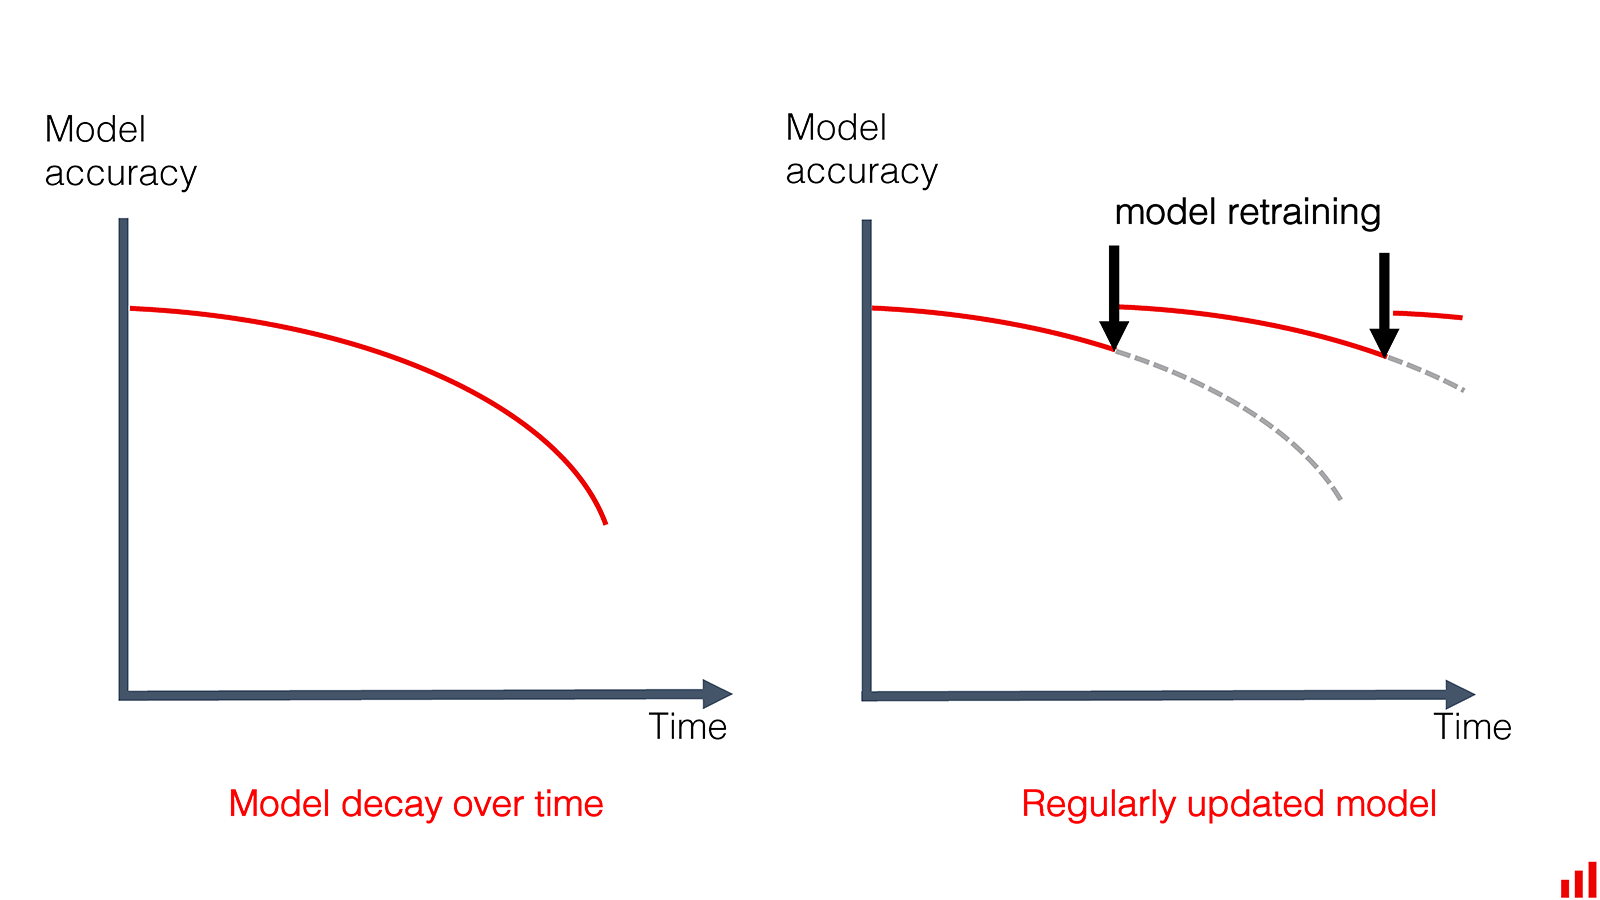

*image source:* [Evidently - ML monitoring](https://www.evidentlyai.com/blog/machine-learning-monitoring-data-and-concept-drift)

**Data drift** refers to changes in the distribution of the features that the ML model receives in production. It may, or may not, cause a decline in model performance, depending on drifted features.

**Concept drift** means that the relation between data and targets has changed, i.e. `f(x)` learned by our models, and almost certainly shows as a degradation in performance.

*Example*:
* With data drift, the relationship between sales channels and volumes remains stable, but the distribution of channels shifts.
* With concept drift, you can observe a decrease in average sales in an offline channel.

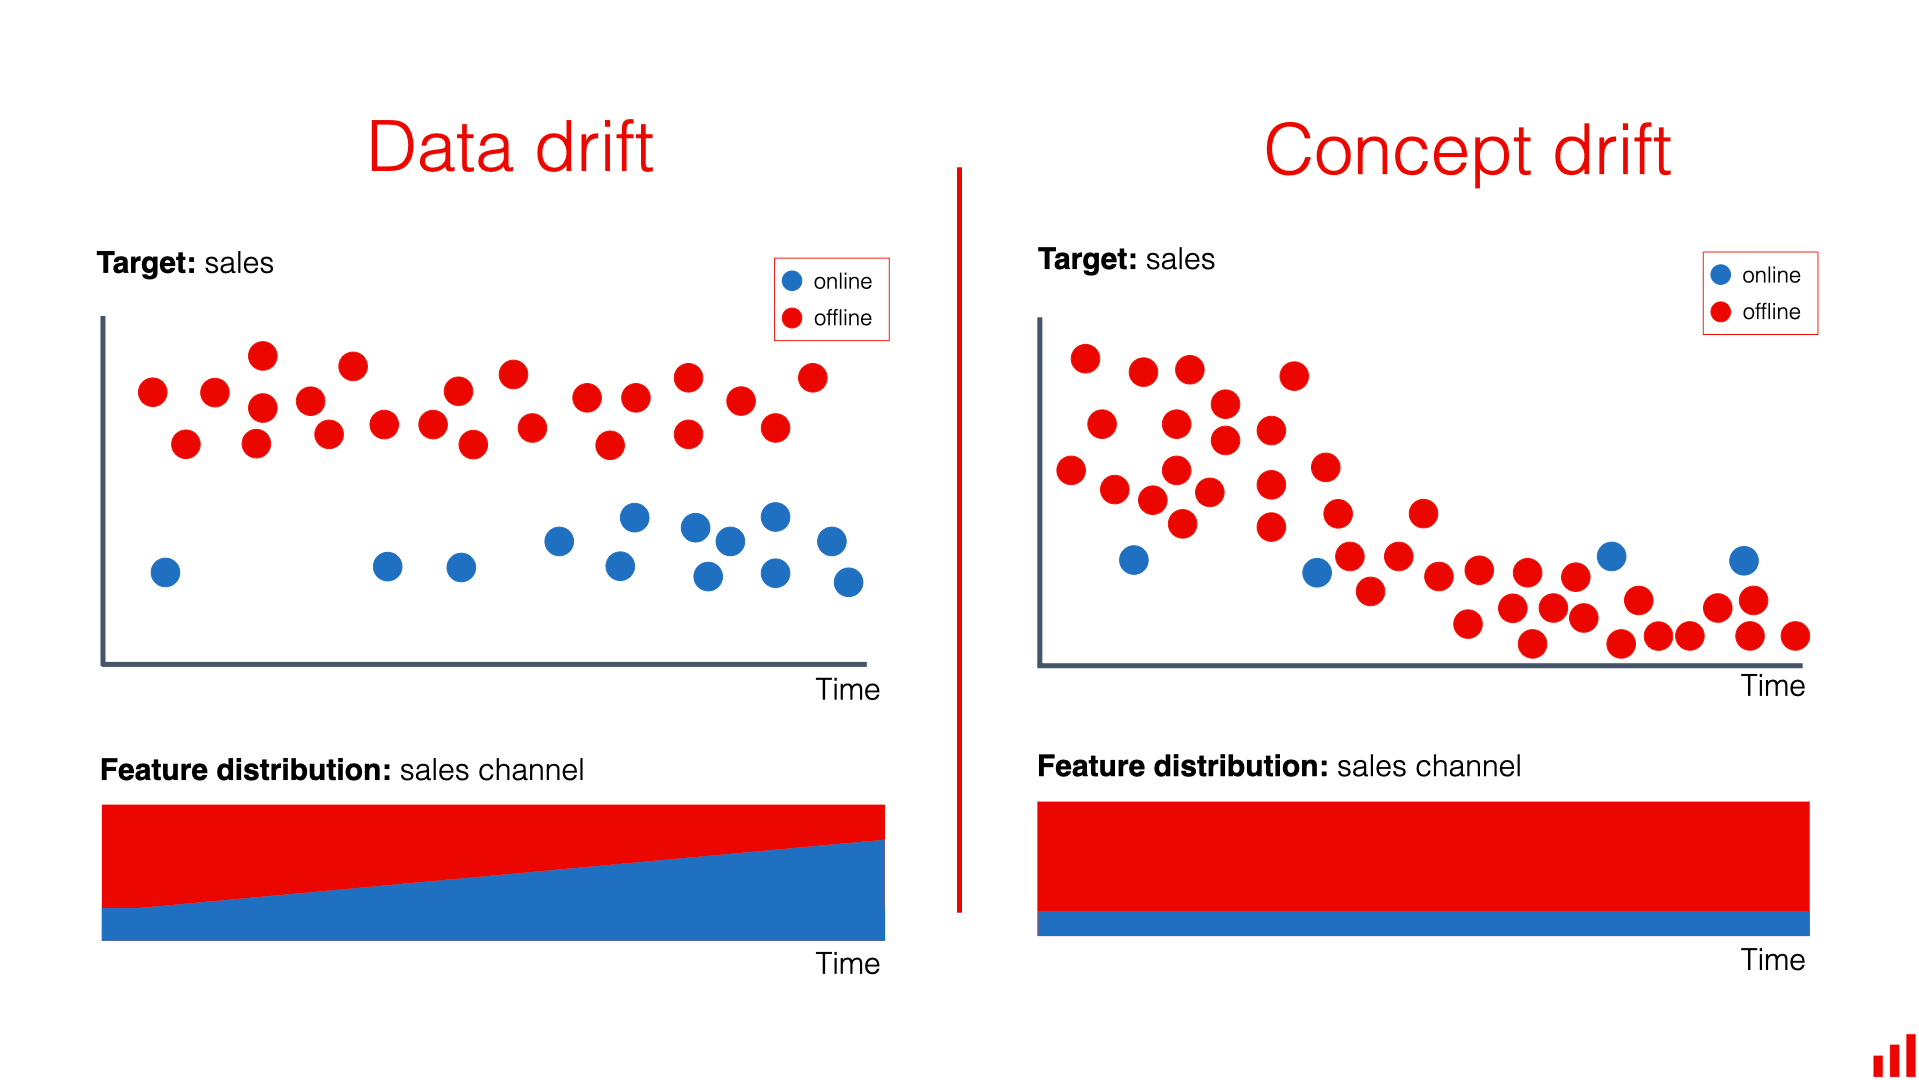

*image source:* [*Evidently - ML in production*](https://www.evidentlyai.com/ml-in-production/data-drift)

## Dataset

We will be using [Women's E-Commerce Clothing Reviews dataset](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews/data), with about 24 thousand reviews of women's clothing. Data contains the review text and also a bit of metadata, which will come in handy in further exercises. Since it's pretty small, we included it in the repository, with just the relevant columns.

We will start with loading the data and checking basic statistics. It will also act as our base data source for most of the notebook. Since published datasets are generally static, they don't show realistic, dynamically changing behavior. Thus, we will simulate the data drift behavior with synthetic, but realistic modifications.

In [ ]:
import pandas as pd


df = pd.read_parquet("data/dataset.parquet")
df

### Exercise 1 (2 points)

Perform basic data quality checks:
1. Data length
2. Column types
3. Five first and last rows
4. Check if there are duplicates
5. Text length distribution ("review" column)
6. Distributions of key features: "age", "item_type" (note that it's categorical), "rating", "recommended"

If there are duplicates in the "review" column, drop those rows.

## Introduction to Evidently

[Evidently](https://www.evidentlyai.com/) is arguably the most popular AI observability and ML monitoring solution. They offer both an open source library and server (which we will be using here), as well as a fully managed cloud offering. While we could build everything from scratch, proper monitoring dashboard requires detecting data types, multiple methods for drift detection (e.g. statistical tests, distance measures), and a lot of visualization methods. Evidently implements it all, and presents the results in convenient, readable dashboards. It can also be used as a data testing framework, working like a Python testing library, instead of using graphical interface.

Data monitoring can be quite similar to testing data quality, and often incorporates it. After all, if the data quality deteriorated, e.g. we get many more missing values, there surely is a problem. Evidently has a lot of tools just for data quality testing, and this will further expand our toolbox from data-centric AI notebook.

Data monitoring requires two sets of data:
1. **Reference dataset** - representative, "standard" data, which we expect in the future. It can be a manually curated, high-quality dataset, or just the whole dataset available at the time of training.
2. **Current dataset** - new batch of data that we gathered recently. It may have labels available, or it may not, depending on the situation.

In the ideal situation, the data distribution is the same for both. **Data drift** happens when current dataset has drifted in its characteristics from the reference data. Model performance may similarly deteriorate, or it may stay the same, for example when only unimportant features drift. For text data, the distribution change can also happen: new topics crop up, customer base changes, they use other vocabulary, we start the service in a new country etc.

**Data drift detection** is a set of statistical techniques to compare those two datasets. There is **no ground truth for drift**! Only the domain experts can decide whether the change is really significant. Observability system aims to create alerts, which should be manually validated. Methods are often based on statistical testing or distance measurement, comparing distributions of features. Almost all are univariate, considering each feature separately.

We will start by monitoring basic data quality. There is a lot of overlap with just regular data quality testing, but some tests additionally compare new data to the reference dataset. For example, we may check if there are no new categories for categorical variables.

Let's create two random subsets of our data. Random sampling should generally result in no significant changes. This can be used for tuning thresholds for alerting and controlling false positives. We will use [default Evidently settings](https://docs-old.evidentlyai.com/reference/api-reference/evidently.test_preset#class-dataqualitytestpreset-columns-optional-list-str-none-1) for monitoring data quality and compare the two.

Those checks are quite basic and include:
- share of missing values (per column)
- share of most common value (per column)
- constant columns
- duplicated columns
- duplicated rows

In [ ]:
from evidently.test_suite import TestSuite
from evidently.test_preset import DataQualityTestPreset

from sklearn.model_selection import train_test_split


df_subset_1, df_subset_2 = train_test_split(df, test_size=0.25, random_state=0)

data_quality = TestSuite(
    tests=[
        DataQualityTestPreset(),
    ]
)

data_quality.run(reference_data=df_subset_1, current_data=df_subset_2)
data_quality.show(mode="inline")

Most of the default checks pass. However, we have three errors with the most common value:
1. `idx` - this is just an ID, so we should ignore it
2. `age` - since this is a numerical value, we don't expect common value to be the same
3. `review` - texts are unique, so we should not check this column for common values

We will build a test suite from scratch and fix those issues. This is done by creating a `TestSuite` object and passing a list of tests. The full list is available [in the documentation](https://docs-old.evidentlyai.com/reference/all-tests), and here we focus on [data quality tests](https://docs-old.evidentlyai.com/reference/all-tests#data-quality). Many of those tests can also work without a reference dataset, e.g. checking if there are any missing values or duplicates. This way, Evidently can even be used just for data quality testing, without any monitoring.

In [ ]:
# this import not the best practice generally, but quite useful here
from evidently.tests import *

data_quality_column_tests = TestSuite(
    tests=[
        TestNumberOfColumns(),
        TestNumberOfConstantColumns(eq=0),
        TestNumberOfDuplicatedRows(eq=0),
        TestNumberOfDuplicatedColumns(eq=0),
        TestColumnsType(),  # expect same column data types
        TestColumnAllUniqueValues(column_name="idx"),
        TestColumnAllUniqueValues(column_name="review"),
        TestNumberOfMissingValues(eq=0),  # expect no missing values
        TestNumberOfOutListValues(column_name="item_type"),
        TestNumberOfOutListValues(column_name="rating"),
        TestNumberOfOutListValues(column_name="recommended"),
    ]
)

data_quality_column_tests.run(reference_data=df_subset_1, current_data=df_subset_2)
data_quality_column_tests.show(mode="inline")

Note the last two tests above for out-of-list values. They are designed for categorical columns, and check if there are new values in the reference dataset. They can be particularly problematic when using one-hot encoding.

What if we did get a new value? Let's say that the frontend and backend teams added a new item type "*Shoes*", and nobody bothered to inform the data science team. Then the test suite should fail for such data.

In [ ]:
df_subset_2_shoes = df_subset_2.copy()
df_subset_2_shoes.loc[df_subset_2_shoes.index[:100], "item_type"] = "Shoes"

data_quality_column_tests.run(
    reference_data=df_subset_1, current_data=df_subset_2_shoes
)
data_quality_column_tests.show(mode="inline")

Our test suite can also be used programmatically, in a regular Python backend code for monitoring, without relying on visual interface. This is done by exporting the test results as dictionary (or as JSON file) and checking its structure. This can also trigger e.g. sending email with warnings.

In [ ]:
data_quality_column_tests.as_dict()

### Exercise 2 (2 points)

Create and run an additional test suite with value tests for the numerical `age` column. Typical checks for numerical columns are simple statistical aggregates of the values distribution:
- value range (minimum and maximum)
- mean or median
- standard deviation
- quantiles

Use the [Evidently documentation](https://docs.evidentlyai.com/reference/all-tests#column-values) as needed.

## Data drift detection

When the distribution of a feature changes between reference and current datasets, we observe a **data drift**. This is sometimes very close to data quality testing. For example, when we start to see much more missing values for a particular feature, the data quality deteriorated, but it has also drifted, since the feature values distribution changed.

Other examples of drift:
- new minimal and maximal values, e.g. lower user ages
- distribution shift towards lower/higher values, e.g. after new marketing campaign for elderly
- completely new distribution, e.g. log-normal instead of normal
- new categories appear, e.g. new products
- change in label distribution, e.g. problem becomes more imbalanced

In NLP especially, there are also more nuanced drifts, e.g. new topics, language change, new out-of-vocabulary words, or general semantic changes in texts. We will consider it later, and for now focus on simpler tabular data.

How to **detect drift**? A typical tool are statistical tests or distance measures. For numerical, categorical, or binary features they can tell us if two samples (reference and current feature values) come from the same distribution. By default, Evidently uses statistical tests for small datasets (due to their power) and distance measures for large datasets (due to their computational efficiency).

The sensitivity of those tools is set with confidence level $\alpha$ or by distance threshold, and they should be tuned to avoid false alerts. This is always a manual, project-dependent or even feature-dependent process.

So the **drift detection procedure** is:
1. Take features `x_ref` and `x_curr`
2. Run statistical test function and get p-value OR compute distance between distributions
3. Check result against the threshold. If failed, alert

[Evidently defaults are](https://docs-old.evidentlyai.com/reference/data-drift-algorithm):
- small dataset ( current + reference size <1000 samples)
  - numerical: two-sample Kolmogorov-Smirnov (K-S) test
  - categorical: chi-squared test
  - binary: proportion difference test for independent samples based on Z-score
  - confidence level $\alpha = 0.95$
- large dataset (>= 1000 samples)
  - numerical: Wasserstein distance
  - categorical: Jensen-Shannon divergence
  - distance threshold $0.1$
- alert about drift if over $1/3$ of features have drifted

Let's check the "age" feature for drift. Randomly splitting the data should, on average, result in no significant change. As before, we will first use Evidently default report, but this time for data drift.

First, let's see a variant where we have a small reference dataset, under 1000 samples.

In [ ]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from sklearn.model_selection import train_test_split


df_subset_1, df_subset_2 = train_test_split(df[:1000], test_size=0.2, random_state=0)

data_drift_report = Report(metrics=[DataDriftPreset()])

data_drift_report.run(reference_data=df_subset_1, current_data=df_subset_2)
data_drift_report.show(mode="inline")

Evidently tries to automatically infer types, known as **schema inference**. It sometimes fails, like here. `idx` is not numerical, and `review` is not categorical, after all!

The simplest option is to explicitly define the data schema, using a `ColumnMapping` object ([documentation](https://docs-old.evidentlyai.com/user-guide/input-data/column-mapping)), similarly to e.g. Apache Spark. **It's always better to provide explicit schema mapping**, as a general rule in data engineering. It's quicker, safer, and more readable in code.

Evidently can use this for reports and test suites. This makes sure that only proper columns are used, appropriate tests are chosen, and adds better visualizations, e.g. time series plots if `datetime` column is specified.

Column types in Evidently ([documentation](https://docs-old.evidentlyai.com/user-guide/input-data/column-mapping#column-mapping)):
1. `id` - sample identifier
2. `datetime` - timestamp, date of gathering a sample
3. `target` and `prediction` - ground truth and predicted values in supervised learning
4. `numerical_features` and `categorical_features` - most typical tabular features
5. `text_features` - raw texts
6. `embeddings` - text embeddings
7. `datetime_features` - temporal features

We will cover NLP-specific types `text_features` and `embeddings` in greater detail in the next notebook, since they use dedicated drift detection methods. For now, let's specify a column mapping.

In [ ]:
from evidently import ColumnMapping

col_mapping = ColumnMapping(
    target="recommended",
    id="idx",
    numerical_features=["age", "rating"],
    categorical_features=["item_type"],
    text_features=["review"],
)

data_drift_report = Report(metrics=[DataDriftPreset()])

data_drift_report.run(
    reference_data=df_subset_1, current_data=df_subset_2, column_mapping=col_mapping
)
data_drift_report.show(mode="inline")

### Exercise 3 (1.5 points)

Create and run data drift report for full dataset. Split it using `idx` column, taking newest 20% of data as current dataset, and all older rows as a reference dataset. Use the previous column mapping. Note which tests are selected for particular columns.

## Population Stability Index

Last useful thing we will cover is how to explicitly select a metric. **Population Stability Index (PSI)** is a popular metric in the financial sector for measuring distribution drift, and it can be calculated for numerical and categorical features. It's convenient to use due to relatively low sensitivity - it alerts only about major shifts. It can be a great choice for a first monitoring system, where you want to quickly set something up and avoid false alarms, and only get alerted about major problems.

Useful references about PSI:
- [What is the population stability index (PSI)?](https://mwburke.github.io/data%20science/2018/04/29/population-stability-index.html)
- [NannyML - Population Stability Index (PSI): A Comprehensive Overview](https://www.nannyml.com/blog/population-stability-index-psi)
- [Evidently.AI - Which test is the best? We compared 5 methods to detect data drift on large datasets](https://www.evidentlyai.com/blog/data-drift-detection-large-datasets)

In [ ]:
from evidently.metrics import ColumnDriftMetric


df = df.sort_values(by="idx")
df_subset_old = df.iloc[: int(0.8 * len(df))]
df_subset_new = df.iloc[int(0.8 * len(df)) :]

data_drift_psi_report = Report(
    metrics=[
        ColumnDriftMetric(column_name="age", stattest="psi"),
        ColumnDriftMetric(column_name="item_type", stattest="psi"),
        ColumnDriftMetric(column_name="rating", stattest="psi"),
        ColumnDriftMetric(column_name="recommended", stattest="psi"),
    ]
)

data_drift_psi_report.run(
    reference_data=df_subset_old, current_data=df_subset_new, column_mapping=col_mapping
)
data_drift_psi_report.show(mode="inline")

Let's introduce a bit of drift now. We will use NumPy generator to shift the `age` column towards larger values. We add values drawn from normal distribution with mean 2.

In [ ]:
from numpy.random import default_rng

df = df.sort_values(by="idx")
df_subset_old = df.iloc[: int(0.8 * len(df))]
df_subset_new = df.iloc[int(0.8 * len(df)) :]

rand_gen = default_rng(seed=0)
df_subset_new["age"] += rand_gen.normal(loc=2, size=len(df_subset_new))

data_drift_psi_report = Report(
    metrics=[ColumnDriftMetric(column_name="age", stattest="psi")]
)

data_drift_psi_report.run(
    reference_data=df_subset_old, current_data=df_subset_new, column_mapping=col_mapping
)
data_drift_psi_report.show(mode="inline")

Now let's check stronger drift, changing age by 5 years on average.

In [ ]:
df = df.sort_values(by="idx")
df_subset_old = df.iloc[: int(0.8 * len(df))]
df_subset_new = df.iloc[int(0.8 * len(df)) :]

rand_gen = default_rng(seed=0)
df_subset_new["age"] += rand_gen.normal(loc=5, size=len(df_subset_new))

data_drift_psi_report = Report(
    metrics=[ColumnDriftMetric(column_name="age", stattest="psi")]
)

data_drift_psi_report.run(
    reference_data=df_subset_old, current_data=df_subset_new, column_mapping=col_mapping
)
data_drift_psi_report.show(mode="inline")

## NLP Data Monitoring

So far, we used tabular data, which is naturally **structured**, in rows and columns. Texts, images, audio and similar data are **unstructured**, with variable length, formatting, and complex structure. No matter what data we operate on, we need some minimal structure for monitoring. This is because we need to measure similarity or dissimilarity between new and old (training) data or model behavior.

When processing text data in NLP, we also often have more nuanced data drift, e.g., new topics, language change, new out-of-vocabulary words, or general semantic changes in texts. As such, we have different approaches, each with specific pros and cons. We have three main choices for creating structured data for monitoring:
1. **Feature extraction** - directly transform text into structured, tabular features. The goal here is not to get features good for training models, but rather understanding the data itself. This is highly interpretable, but features to create can sometimes be not obvious or costly to compute.
2. **Embeddings** - use a pretrained embeddings model to get a constant length, numerical vector for each text. Since they are basically points in a multidimensional space, we can measure the similarity between them. This can encode a lot of complex semantic information, but results may be hard to interpret, and rely a lot on the quality of the encoder.
3. **LLM judge** - use an LLM model with an appropriate prompt to detect and describe behavior. Since LLMs are very flexible, they can detect and classify e.g. text style, toxicity, or detect whether a text contains personally identifiable information (PII). Such an approach can be very powerful for complex monitoring tasks, but has all the downsides of LLMs (cost, verbosity, wrongly formatted outputs, hallucinations, etc.).

We won't consider the last case in this notebook, but if you're interested, here are some useful sources:
- [Evidently.AI blog - LLM-as-a-judge: a complete guide to using LLMs for evaluations](https://www.evidentlyai.com/llm-guide/llm-as-a-judge)
- [Evidently.AI blog - Wrong but useful: an LLM-as-a-judge tutorial](https://www.evidentlyai.com/blog/llm-as-a-judge-tutorial)
- [Evidently docs - LLM as a judge](https://docs.evidentlyai.com/tutorials-and-examples/cookbook_llm_judge)
- [Evidently docs - Text evals with LLM-as-judge](https://docs.evidentlyai.com/user-guide/customization/llm_as_a_judge)

We will continue to use the same dataset. It is **multimodal** - we have both regular tabular features (e.g. age) and unstructured text. In those cases, feature extraction is particularly useful, since we can then process all columns in a similar way.

## Feature extraction for text monitoring

Evidently by default uses feature extraction for monitoring text features in `TextEvals`. Let's see how it works.

Using features for text requires loading some NLTK elements beforehand, which Evidently uses underneath for computing them.

In [ ]:
import nltk

nltk.download("words")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("vader_lexicon")

We will simulate a drop-in quality in our store, which will also cause drift in review texts. The data will be split as:
- reference: positive reviews (rating 4–5)
- current: negative reviews (rating 1–2)

This will also remove mixed or neutral ones for clarity. We will also downsample dataset a bit for speed.

In [ ]:
from evidently import ColumnMapping


df_pos_ref = df[df["rating"] > 3].sample(
    n=5000, replace=True, ignore_index=True, random_state=0
)
df_neg_curr = df[df["rating"] < 3].sample(
    n=5000, replace=True, ignore_index=True, random_state=0
)

col_mapping = ColumnMapping(
    target="recommended",
    id="idx",
    numerical_features=["age", "rating"],
    categorical_features=["item_type"],
    text_features=["review"],
)

In [ ]:
from evidently.metric_preset import TextEvals
from evidently.report import Report


text_overview_report = Report(metrics=[TextEvals(column_name="review")])

text_overview_report.run(
    reference_data=df_pos_ref, current_data=df_neg_curr, column_mapping=col_mapping
)
text_overview_report.show(mode="inline")

Evidently computed features typical for NLP:
- text length
- number of sentences
- sentiment (with a simple model from NLTK)
- out-of-vocabulary (OOV) words
- non-letter characters

Problems with data quality or data drift often cause changes in those features. Note that they can be easily combined with any other tabular features, which is beneficial for multimodal datasets like this one.

### Exercise 4 (1.5 points)

Combine tests for quality of tabular features, which we used in the previous exercises, (`DataQualityPreset`), with testing the `review` column.

## NLP data drift detection

When using extracted features, drift detection for NLP or multimodal data is basic. Since we really have a set of tabular features, we can also just use statistical tests or distance measures. While useful and interpretable, those simple features may not necessarily capture more complex semantic changes.

However, for raw texts, another interesting technique can be used - **domain classifier**, also known as **model-based drift detection**. The idea is to check if two datasets (reference and current) are differentiable by training an ML classifier to do just that. If it's accurate enough, it means that they are visibly different.

Steps:
1. Reference dataset (e.g. texts) gets label 0, and current dataset gets label 1
2. Train a classifier to differentiate between those two datasets
3. Calculate AUROC (ROC AUC)
4. If above threshold, datasets are differentiable, a report drifts

This is a very general approach, and can be used for any data really, e.g. texts, images, or even tabular features. It can also detect multivariate drift by using many tabular features at once. For unstructured data, the features for the classifier are typically either simple TF-IDF or Sentence Transformer embeddings.

Useful references:
- [Evidently.AI blog - Data quality monitoring and drift detection for text data](https://www.evidentlyai.com/blog/evidently-data-quality-monitoring-and-drift-detection-for-text-data)
- [Evidently docs - Data drift algorithm for text data](https://docs.evidentlyai.com/reference/data-drift-algorithm#text-data)
- [NannyML blog — Detect Data Drift Using Domain Classifier in Python
](https://www.nannyml.com/blog/data-drift-domain-classifier)
- ["Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift" S. Rabanser et al.](https://arxiv.org/abs/1810.11953)

For drift detection in text features, Evidently by default uses TF-IDF with 1-layer neural network for classification ([source](https://github.com/evidentlyai/evidently/blob/42d836ab3a7f92fdf171cee12ea91acc952659c2/src/evidently/utils/data_drift_utils.py#L105)). This approach has a few advantages:
- word-level interpretability can show most influential words
- text-level interpretability identifies most extreme cases (where classifier is most confident)
- easy to implement
- very fast

50–50% train-test split is used, since the model generalization is not that important, just distinguishing train and test samples. The default AUROC threshold is 0.55, which is often too strict, and should be increased when you expect e.g., seasonal changes in text topicality or rare model retraining.

In [ ]:
from evidently.metrics import DatasetDriftMetric, DataDriftTable

data_drift_text_report = Report(
    metrics=[
        DatasetDriftMetric(columns=["review"]),
        DataDriftTable(columns=["review"]),
    ]
)

data_drift_text_report.run(
    reference_data=df_pos_ref, current_data=df_neg_curr, column_mapping=col_mapping
)
data_drift_text_report.show(mode="inline")

This approach assumes that our data is simple enough for that type of classifier. It works much worse, however, for complex problems, e.g., multilingual datasets. After all, we typically use transformers exactly for this reason. Models based on embeddings from pretrained transformers are also very efficient and give better classification quality, albeit are not that interpretable.

Evidently allows creating custom metrics and tests. In the simplest case, they are just Python functions, taking an `InputData` object and returning a float score, like AUROC for domain classifier. This is the most flexible option available, while also taking advantage of visualization and other tools in Evidently.

To use the metric, `CustomValueMetric` object is used, just like built-in presets and metrics. `CustomValueTest` additionally tests if the resulting values are in appropriate ranges.

`InputData` has the following attributes:
```
    reference_data: Optional[pd.DataFrame]
    current_data: pd.DataFrame
    reference_additional_features: Optional[pd.DataFrame]
    current_additional_features: Optional[pd.DataFrame]
    column_mapping: ColumnMapping
    data_definition: DataDefinition
    additional_data: Dict[str, Any]
```

Custom visualizations and dashboards can also be created, but require getting pretty deep into Evidently features. If you are interested, the useful references are:
- [Evidently examples — How to create a metric on top of a Python function?](https://github.com/evidentlyai/evidently/blob/main/examples/how_to_questions/how_to_build_metric_over_python_function.ipynb)
- [Evidently examples — How to make custom metric and test?](https://github.com/evidentlyai/evidently/blob/main/examples/how_to_questions/how_to_make_custom_metric_and_test.ipynb)

### Exercise 5 (2 points)

Finish the implementation of `review_embedding_domain_classifier()` function, which uses a domain classifier for the `"review"` column, based on Sentence Transformers and logistic regression.

Steps:
1. Extract lists of reference and current texts
2. Create vectors with labels: reference 0, current 1
3. Merge texts and labels, and then do 50–50% train-test split (with stratification).
4. Compute the embeddings with `all-MiniLM-L6-v2` SentenceTransformers model.
5. Train logistic regression.
6. Compute and return AUROC (ROC AUC) on a test set. Remember to pass positive class probabilities to the function.

Note how the drift score changed in this method, compared to previous bag-of-words approach.

In [ ]:
from evidently.base_metric import InputData
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


def sentence_transformer_drift(data: InputData) -> float:
    # extract texts and labels
    ...

    # train-test split
    ...

    # Sentence Transformers embeddings
    ...

    # train and evaluate classifier
    ...

#### Verification

In [ ]:
from evidently.metrics import DatasetDriftMetric, DataDriftTable
from evidently.metrics.custom_metric import CustomValueMetric


data_drift_text_report = Report(
    metrics=[
        DatasetDriftMetric(columns=["review"]),
        DataDriftTable(columns=["review"]),
        CustomValueMetric(
            func=sentence_transformer_drift, title="Sentence transformer AUROC"
        ),
    ]
)

data_drift_text_report.run(
    reference_data=df_pos_ref, current_data=df_neg_curr, column_mapping=col_mapping
)
data_drift_text_report.show(mode="inline")

## Embeddings drift

Embeddings are a powerful tool for many NLP tasks, in particular classification and similarity searching (semantic search). The latter is particularly important in the context of LLMs and RAG. This can be quite useful in detecting changes in the content of knowledge bases for RAG.

Based on research by Evidently.AI:

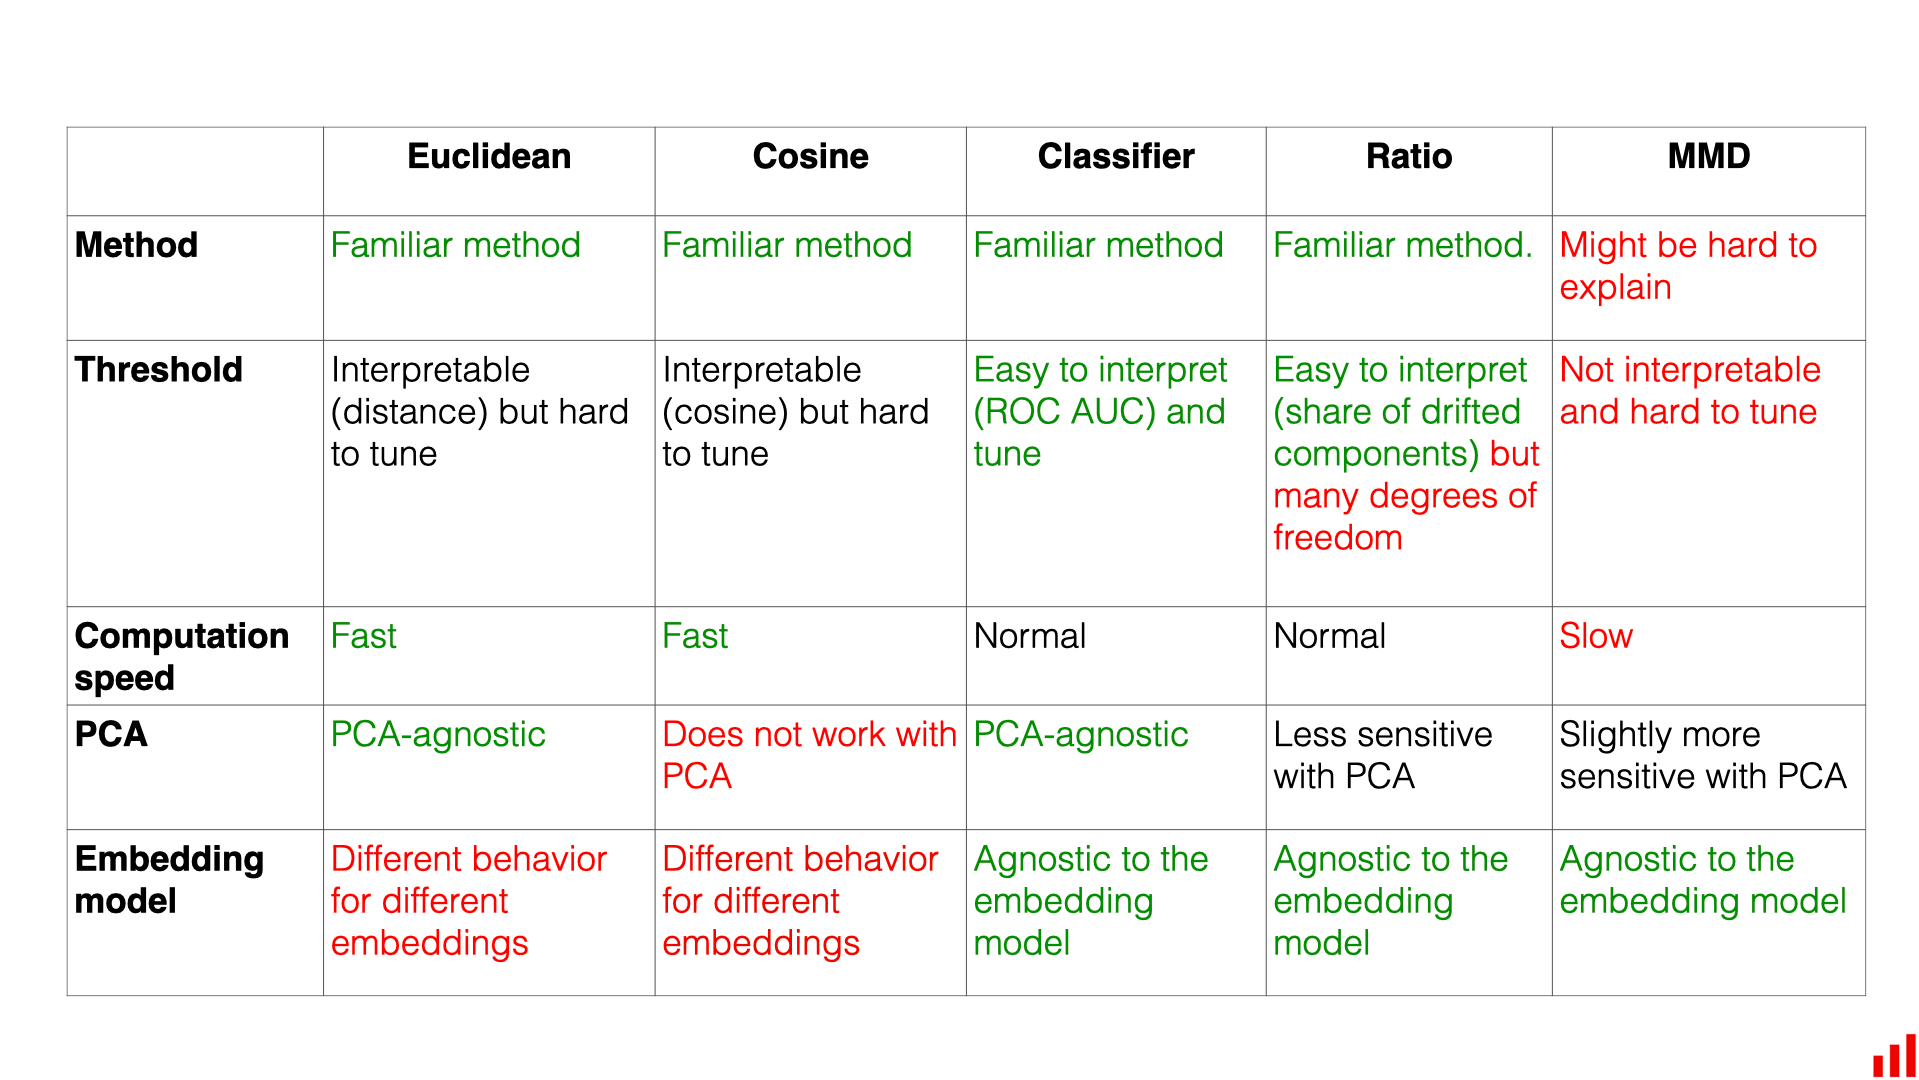

*image source:* [Evidently - Embedding drift detection](https://www.evidentlyai.com/blog/embedding-drift-detection)

We already covered the domain classifier approach. It is the default option, but it's not always the best option. For example, imagine we use a RAG system with search based on cosine similarity, with an embedding model that does not change. Then using a cosine similarity for drift detection makes much sense, since systems are then well aligned with each other.

Advantages of distance-based approach:
- faster
- avoids any potential problems with training a classifier, e.g., overfitting, class imbalance
- can monitor change over time by checking distance distribution
- very interpretable in case of cosine distance

Useful resources:
- [Evidently.AI blog: Shift happens: we compared 5 methods to detect drift in ML embeddings](https://www.evidentlyai.com/blog/embedding-drift-detection)
- [Evidently docs: Embeddings drift parameters](https://docs-old.evidentlyai.com/user-guide/customization/embeddings-drift-parameters)

Evidently requires embedding dimensions to be separate columns, so 768-element embeddings will result in 768 columns.

Column mapping for embeddings is quite specific. To specify this, we need to set `.embeddings` attribute of column mapping to a dictionary, where keys are embedding names and values are lists of columns. This is also flexible, allowing many different embeddings at the same time. Any column with this type will also get visualized with a t-SNE plot, which helps to understand the characteristics of the differences, e.g., if they are clustered.

We will calculate embeddings and then check the default method, which is model-based and uses SGD classifier. The result should be quite similar to our previous approach.

In [ ]:
from sentence_transformers import SentenceTransformer


def get_df_with_embeddings(
    df: pd.DataFrame, model_name: str, text_col: str
) -> tuple[pd.DataFrame, list[str]]:
    df = df.copy()

    emb_model = SentenceTransformer(model_name)
    embeddings = emb_model.encode(df[text_col])

    n_dims = embeddings.shape[1]
    col_names = [f"{model_name}_{i}" for i in range(n_dims)]

    df_embeddings = pd.DataFrame(embeddings, columns=col_names)
    df = pd.concat([df, df_embeddings], axis="columns")

    return df, col_names

In [ ]:
from copy import deepcopy
from evidently.metrics import EmbeddingsDriftMetric


model_name = "all-MiniLM-L6-v2"
text_col = "review"
df_pos_ref_emb, emb_col_names = get_df_with_embeddings(df_pos_ref, model_name, text_col)
df_neg_curr_emb, emb_col_names = get_df_with_embeddings(
    df_neg_curr, model_name, text_col
)

col_mapping_emb = deepcopy(col_mapping)
col_mapping_emb.embeddings = {f"{model_name} embeddings": emb_col_names}

df_pos_ref_emb

In [ ]:
report = Report(metrics=[EmbeddingsDriftMetric(f"{model_name} embeddings")])
report.run(
    reference_data=df_pos_ref_emb,
    current_data=df_neg_curr_emb,
    column_mapping=col_mapping_emb,
)
report.show(mode="inline")

### Exercise 6 (2 points)

Try out other approaches to detecting embeddings drift, built into Evidently. [Documentation](https://docs-old.evidentlyai.com/user-guide/customization/embeddings-drift-parameters#embedding-drift-detection-methods) and `drift_method` argument will be useful. Try:
- distance-based with Euclidean distance
- distance-based with cosine distance
- maximum model discrepancy (MMD)

Measure time for each one, and note the drift score. Comment, which method for embeddings drift would you choose in practice, among all of those that we have tried?

If you are interested, you can read more about MMD here:
- [Evidently.AI blog](https://www.evidentlyai.com/blog/embedding-drift-detection#maximum-mean-discrepancy)
- [Maximum Mean Discrepancy (MMD) in Machine Learning](https://www.onurtunali.com/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html)
- [Maximum Mean Discrepancy (distance distribution)](https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution)

// comment here

# Model monitoring

Model monitoring is a process of continuously tracking the performance of the model itself in production. It ensures they maintain accuracy, relevance, and reliability when handling real-world data.

Dedicated metrics such as accuracy, error rates, and prediction distributions allow us to detect when model's performance begins to deviate from expectations.

In this section, we will first train an Amazon review sentiment prediction model, using the English part of [The Multilingual Amazon Reviews Corpus](https://huggingface.co/datasets/defunct-datasets/amazon_reviews_multi/tree/f256e74ee2353b7c7854f86f86200f220531caa4). The dataset is accessible via one of its revisions on the Hugging Face.

A key part of this task will be a model's simulated "production" period, when it receives new, unlabeled reviews. This phase mimics real-world conditions, where the model must handle incoming data without prior labels, emphasizing the importance of continuous monitoring and detecting potential concept drift. By tracking how the model deals with these new reviews, we can assess its adaptability and determine if retraining or adjustment is necessary to maintain performance.

In [ ]:
from datasets import load_dataset


original_ds = load_dataset(
    "amazon_reviews_multi", "en", revision="f256e74", trust_remote_code=True
)
original_ds

The data is already split, with 200 000 samples for training and 5 000 in the validation and test sets.

We can now take a closer look at the dataset and perform some basic checks as well as the deduplication.

In [ ]:
import pandas as pd

df = pd.DataFrame(original_ds["train"])

df

In [ ]:
df.info()

In [ ]:
df["product_category"].value_counts()

In [ ]:
df["review_body"].str.len().plot.hist(title="Text lengths distribution")

In [ ]:
df["stars"].value_counts(ascending=True).plot.bar(
    title="Review ratings distribution", rot=0
)

In [ ]:
df["review_body"].value_counts().head(5)

Since our analysis shows that there are duplicates in the dataset, we will drop them.

Now we need:
- "training" data for train/valid/test subsets
- "production" data to simulate new data during model deployment

We will use the original testing set from the dataset as our production data. For training stage, we will use the validation subset for testing, and train the classifier on Sentence Transformer embeddings with cross-validation.

In [ ]:
df_production = original_ds["test"].to_pandas()
df_test = original_ds["validation"].to_pandas()
df_train = original_ds["train"].to_pandas().drop_duplicates("review_body")

df_train

### Exercise 7 (2 points)

For simplicity, we will transform 5-star labels into 2 sentiment levels: negative and positive.

1. Remove rows with 3 stars, i.e. neutral or mixed reviews.
2. Map 1 and 2 stars to class 0 (negative), and "negative" sentiment.
3. Map 4 and 5 stars to class 1 (positive), and "positive" sentiment.

In [ ]:
def stars_to_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    # remove 3-stars rows
    
    # create maps (dictionaries)

    # map things as necessary
    df["sentiment"] = ...
    df["label"] = ...
    
    return df

#### Validation

In [ ]:
df_production = stars_to_sentiment(df_production)
df_test = stars_to_sentiment(df_test)
df_train = stars_to_sentiment(df_train)

df_train["label"].value_counts(normalize=True).plot.bar()

## Model training

We will train the logistic regression on embeddings from Sentence Transformers. However, now we will use a larger model, since the task is more challenging. For testing, we will use accuracy, F1-score and Matthews correlation coefficient (MCC). For speed, we will use 20 thousand texts (~10%) from the training data.

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split


# downsample for speed
if len(df_train) > 20000:
    df_train, _ = train_test_split(
        df_train, train_size=20000, stratify=df_train["label"], random_state=0
    )


model = SentenceTransformer("all-mpnet-base-v2")
X_train = model.encode(df_train["review_body"].tolist(), show_progress_bar=True)
X_test = model.encode(df_test["review_body"].tolist(), show_progress_bar=True)
X_production = model.encode(df_production["review_body"].tolist(), show_progress_bar=True)

y_train = df_train["label"]
y_test = df_test["label"]

clf = LogisticRegressionCV(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"F1: {f1_score(y_test, y_pred, average='macro'):.2%}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.2%}")

## Monitoring model performance

Real-world data may drift from the test data in various ways. However, for new data, we may not necessarily get a label easily or fast. This is particularly true for manually annotated data. Instead, we can estimate the model performance on new data without labels, using dedicated algorithms. [NannyML

[NannyML](https://www.nannyml.com/library) is an open-source Python library designed to monitor and estimate the performance of deployed models without needing access to target labels. It detects data drift and links these alerts to changes in model performance, making it a powerful tool for data scientists to maintain trust and visibility in their models post-deployment. It has solutions for both classification (**Confidence-Based Performance Estimation (CBPE)**) and regression (**Direct Loss Estimation (DLE)**).

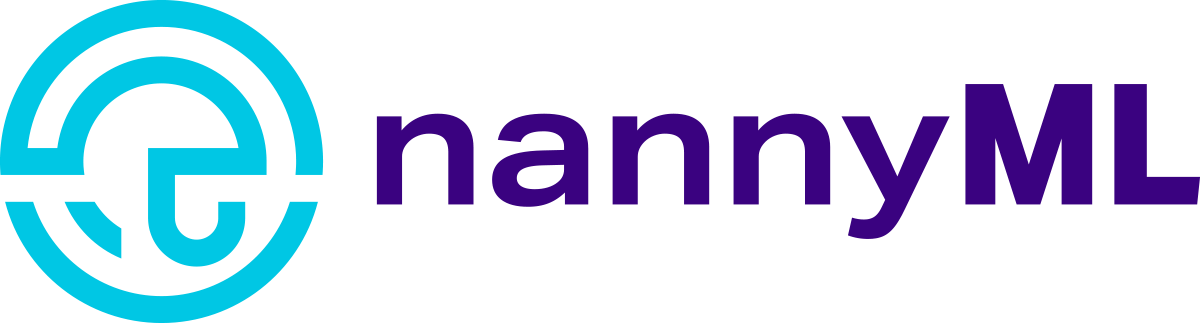

CBPE helps us approximate metrics like F1-score by analyzing probabilistic outputs and distributional patterns, enabling us to monitor the model's performance as it encounters new, unlabeled data in production. This approach offers an efficient way to track performance over time without labeling.

We have previously prepared the `production` subset, which simulates real-world data without known ground truth labels.

We will also need a reference dataset, to compare to and also to perform **probability calibration**. A major assumption of CBPE is a well-calibrated classifier, which accurately predicts probabilities. While training with log-loss (cross-entropy) typically results in well-calibrated models, NannyML also checks this using the reference data, and calibrates the classifier if necessary. In order to avoid overfitting, this needs to be a dataset separate from the training data.

In [ ]:
y_pred_test = clf.predict_proba(X_test)
y_pred_production = clf.predict_proba(X_production)

NannyML operates on Pandas DataFrames, so we need to reformat our data a bit.

In [ ]:
import numpy as np


def create_scores_dataframe(pred_probas: list[dict]) -> pd.DataFrame:
    df = pd.DataFrame(
        pred_probas[:, 1],
        columns=["predicted_probability"]
    )

    df["pred_label"] = np.argmax(pred_probas, axis=1)
    df["pred_label"] = df["pred_label"].astype(int)
    
    return df

In [ ]:
test_predictions_df = create_scores_dataframe(y_pred_test)
prod_predictions_df = create_scores_dataframe(y_pred_production)

test_predictions_df.head()

For test data, we need to add ground truth label, in order to perform probability calibration. For production data, we assume that target labels aren't available at this point in time.

In [ ]:
test_predictions_df["true_label"] = df_test["label"].values
test_predictions_df.head()

Now we can finally use CBPE. It requires fitting like scikit-learn estimators, and performs probability calibration if necessary. After that, we can use it to estimate the F1-score for our simulated production data.

In [ ]:
from nannyml import CBPE

cbpe_estimator = CBPE(
    y_pred_proba="predicted_probability",
    y_pred="pred_label",
    y_true="true_label",
    problem_type="classification_binary",
    metrics="accuracy",
)
cbpe_estimator.fit(test_predictions_df)

results = cbpe_estimator.estimate(prod_predictions_df)
results.plot()

Plot elements:
- X axis: data chunks; here those are just non-overlapping groups of rows, but they could be e.g. time-ordered batches
- Y axis: metric value
- vertical line: separates reference and production data
- red lines: thresholds, 3 standard deviations from the mean of reference metric
- purple line and boxes: estimated performance metric and confidence

If model performance exceeds a threshold, CBPE triggers an alert, indicating that the model performance may be degrading.

In this example, the estimated accuracy remains stable across both reference and analysis periods, showing that the model's performance in production aligns well with the test phase. This stability is reassuring, as it allows us to monitor the model's expected performance over time without needing any labels on the production data.

### Exercise 8 (2 points)

When we eventually get the labels for production data, we can calculate the **realized** performance. Since here we have both, we can compare the estimate with realized performance. We want those values to be as close as possible. With NannyML, this is very similar to CBPE estimation, but uses `PerformanceCalculator` class instead.

Calculate and plot estimated and realized performance. Use [NannyML docs](https://nannyml.readthedocs.io/en/stable/nannyml/nannyml.performance_calculation.calculator.html) as necessary. The blue line on the plot will show the actual performance.

You will need to add labels to production data, similarly to what we did with test data before.

In [ ]:
# add labels to production data


# create and fit performance calculator


# calculate results
calculator_results = ...

#### Verification

In [ ]:
results.compare(calculator_results).plot()

## Model drift detection

A serious challenge in model monitoring is model drift, particularly caused by concept drift, when the relation between data and labels changes. When data drift is the change in $P(X)$, the concept drift is the change in $P(Y|X)$. This can happen due to evolving language patterns, changes in user behavior, or external factors that alter the context of the data. In many cases, an appropriately robust model can withstand data drift, but typical models simply cannot adapt to strong concept drift, and require retraining and capturing the changing patterns.

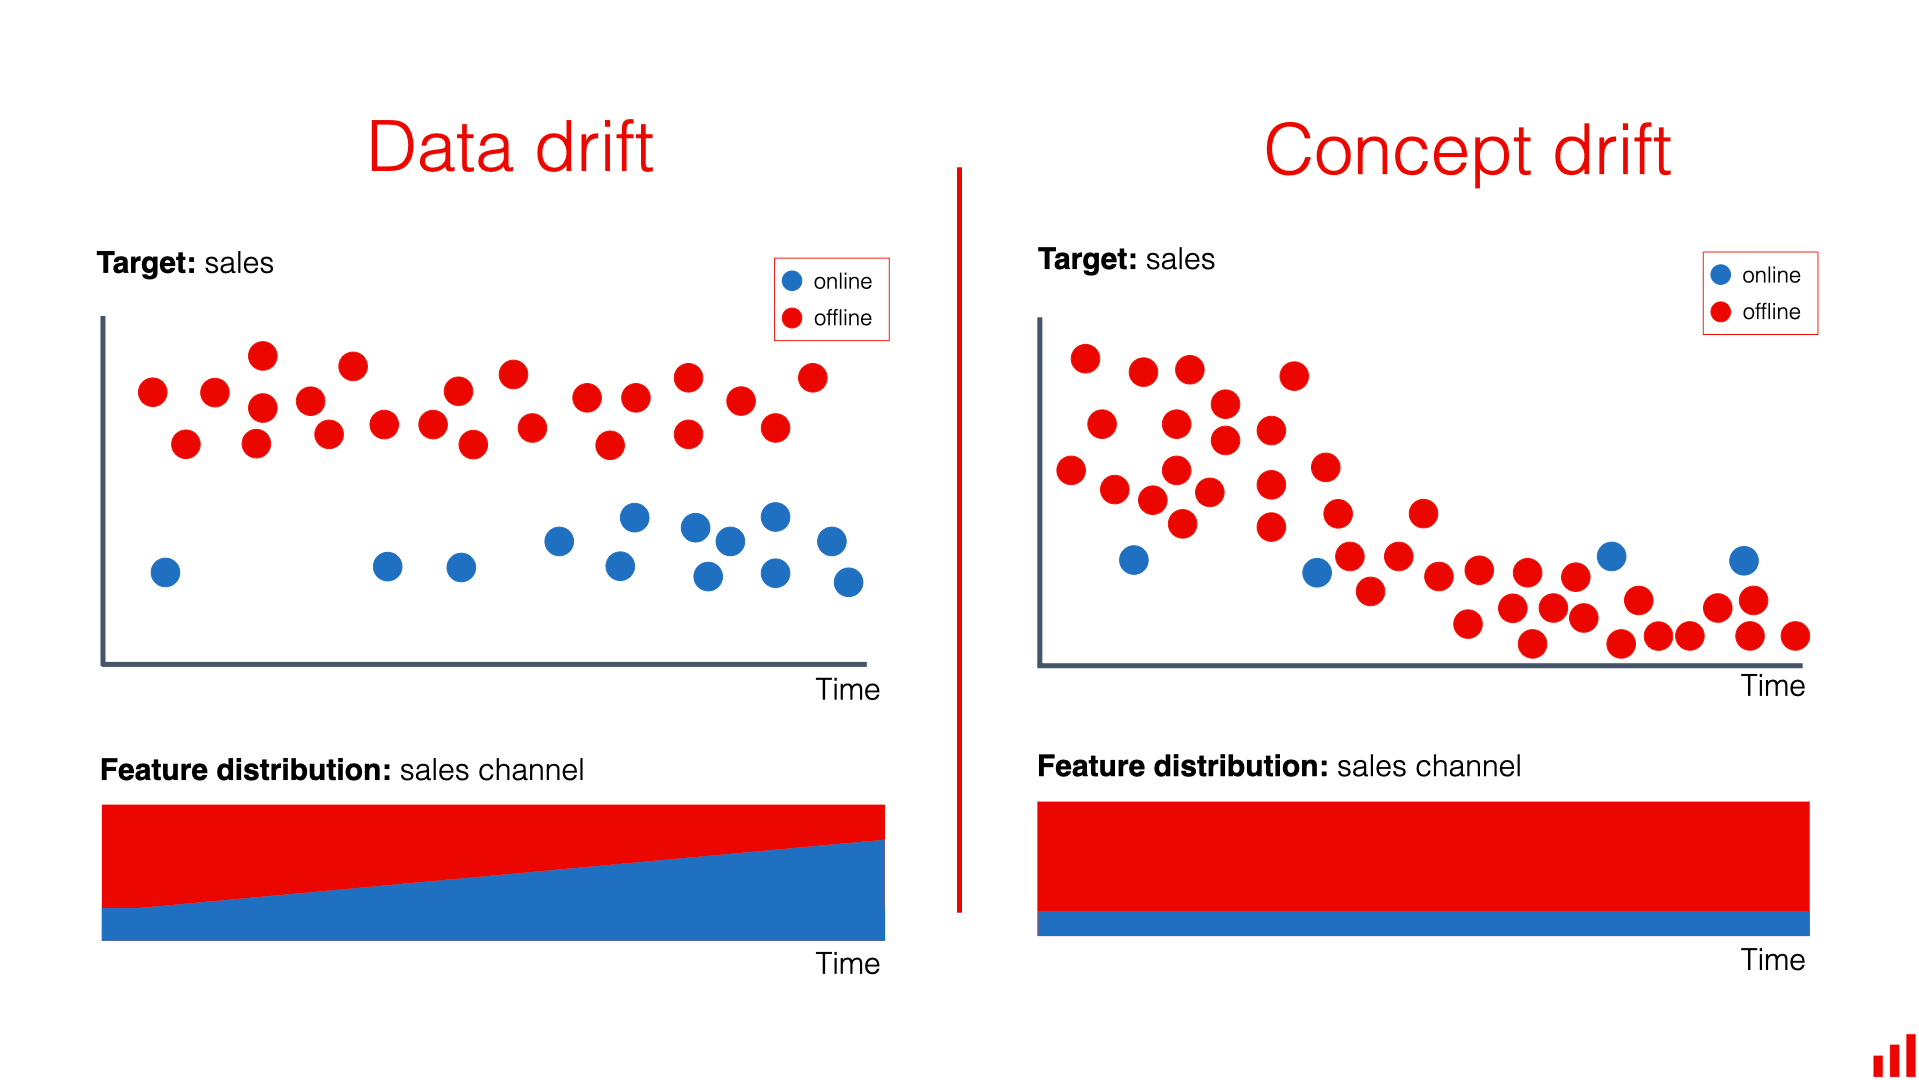

Concept drift ranges from **gradual drift** to **sudden drift**. Gradual change is slower and often expected, as the world incrementally changes and the model becomes less relevant. However, some changes are more abrupt and dramatic, causing sudden drift, e.g. COVID-19 pandemic. While we can try to algorithmically detect gradual drift, the sudden drift is caused by large shocks and is typically known from external knowledge.

To simulate model drift via concept drift, we will use item categories:
- training and reference data (train, valid, test) - `"home"`
- production data - `"industrial_supplies"`

One could argue that this is really a data drift, since the data changed. However, the relation between data $X$ and labels $Y$ is itself different in those two data segments, and we can treat this as concept drift. Furthermore, those product categories should be relatively close to each other semantically, without any artificially drastic drift.

In [ ]:
from sklearn.model_selection import train_test_split


df_all = pd.concat(
    [
        original_ds["train"].to_pandas(),
        original_ds["validation"].to_pandas(),
        original_ds["test"].to_pandas(),
    ],
    ignore_index=True
)
df_all = df_all.drop_duplicates("review_body")
df_all = stars_to_sentiment(df_all)

df_home = df_all[df_all["product_category"] == "home"]
df_home_train, df_home_test = train_test_split(df_home, test_size=0.25, random_state=0)

df_industrial = df_all[df_all["product_category"] == "industrial_supplies"]

In [ ]:
df_home

In [ ]:
df_industrial

The training steps are identical as before, we just need to replace the datasets with the new ones.

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")
X_train = model.encode(df_home_train["review_body"].tolist(), show_progress_bar=True)
X_test = model.encode(df_home_test["review_body"].tolist(), show_progress_bar=True)
X_production = model.encode(df_industrial["review_body"].tolist(), show_progress_bar=True)

y_train = df_home_train["label"]
y_test = df_home_test["label"]

clf = LogisticRegressionCV(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"F1: {f1_score(y_test, y_pred, average='macro'):.2%}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.2%}")

Like before, we now will calculate predictions for test and production data. Since we simulate the production period, we don't use labels there.

In [ ]:
y_pred_test = clf.predict_proba(X_test)
y_pred_production = clf.predict_proba(X_production)

test_predictions_df = create_scores_dataframe(y_pred_test)
prod_predictions_df = create_scores_dataframe(y_pred_production)

test_predictions_df["true_label"] = df_home_test["label"].values

As before, we will monitor our model using `CBPE` and `PerformanceCalculator`.

In [ ]:
cbpe_estimator = CBPE(
    y_pred_proba="predicted_probability",
    y_pred="pred_label",
    y_true="true_label",
    problem_type="classification_binary",
    metrics="accuracy",
)
cbpe_estimator.fit(test_predictions_df)

results = cbpe_estimator.estimate(prod_predictions_df)
results.plot()

The calculator indicates that the drift occurred for the "production period". This is despite the fact that we chose product categories that should be relatively similar. However, in practice we could expect a gradual mixing of categories, rather than a hard cutoff like here. Therefore, in practice, the drift may not be so easily detectable.

The key is to use the resources and tools that we have in a given time, try to notice the drift early, and take preemptive measures to prevent further damage.